In [61]:
import pandas as pd
import numpy as np

import xgboost
import scipy.stats as stats

import lightgbm as lgb


from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from matplotlib import pyplot as plt

from datetime import datetime
import ephem

import geopy.distance


In [2]:
SEED = 42


In [3]:
# Define the function to return the SMAPE value
def smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 6
    )

In [63]:
df = pd.read_csv('new_train.csv')
df.head()

,waktu_setempat,id_jalan,id_titik_mulai,id_titik_akhir,rerata_kecepatan,lanes,lanes:forward,lit,maxspeed,mulai_lat,mulai_lon,akhir_lat,akhir_lon,distance
0,2020-02-01 01:00:00+00:00,691007296,21390008,1425033102,29.126,3.0,2.0,yes,30 mph,51.434928,-0.161176,51.434975,-0.161090,0.0000
1,2020-02-01 01:00:00+00:00,47010584,1677092762,579493410,46.576,NaN,NaN,yes,30 mph,51.623990,-0.176398,51.623811,-0.176424,0.0106
2,2020-02-01 01:00:00+00:00,22932408,26486694,1930267566,36.587,NaN,NaN,yes,20 mph,51.452530,-0.152437,51.452749,-0.151896,0.0280
3,2020-02-01 01:00:00+00:00,142479648,1111592522,3775231113,34.063,3.0,1.0,yes,20 mph,51.465851,-0.154188,51.465654,-0.155334,0.0503
4,2020-02-01 01:00:00+00:00,8504977,5940503398,5940503394,38.336,2.0,NaN,yes,30 mph,51.530289,-0.228343,51.530197,-0.227949,0.0000


In [62]:
def prepare_data(df):
    df = df.drop(['lanes', 'lanes:forward', 'lit'], axis=1)

    unique_maxspeed = df['maxspeed'].unique()
    max_speed = []
    for data in tqdm(df['maxspeed'].to_numpy(), desc='Convert to kph'):
        if data == '30 mph':
            max_speed.append(48.2803)
        elif data == '20 mph':
            max_speed.append(32.1869)

    df['maxspeed'] = max_speed

    # unique_jalan = np.sort(df['id_jalan'].unique(), axis=0, kind='mergesort')
    # id_jalan = []

    # for data in tqdm(df['id_jalan'].to_numpy(), desc='Convert id_jalan'):
    #     idx = np.where(unique_jalan == data)[0].sum()
    #     id_jalan.append(idx)

    # df['id_jalan'] = id_jalan

    distance_2 = []
    for data in tqdm(df[['mulai_lat','mulai_lon','akhir_lat','akhir_lon']].to_numpy(), desc='Calculating straight distance'):
        coords_1 = (data[0] , data[1])
        coords_2 = (data[2] , data[3])
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        distance_2.append(dist)
    df['distance_2'] = distance_2

    is_weekend = []
    is_night = []
    is_rush_hour = []
    date = []
    hour = []

    uk_observer = ephem.Observer()
    uk_observer.lat = '51.5074'  # Latitude of London
    uk_observer.lon = '-0.1278'  # Longitude of London


    for data in tqdm(df['waktu_setempat'].to_numpy(), desc='time categorization'):
        datetime_obj = datetime.strptime(data, '%Y-%m-%d %H:%M:%S%z')
        day_of_week = datetime_obj.weekday()
        if day_of_week >= 5:
            is_weekend.append(1)
        else:
            is_weekend.append(0)
        date_component = datetime_obj.strftime('%Y-%m-%d')
        hour_component = datetime_obj.strftime('%H')
        date.append(date_component)
        hour.append(int(hour_component))
        # Set the observer's date and time to the input UTC time
        uk_observer.date = datetime_obj

        # Calculate sunrise and sunset times
        sunrise = uk_observer.previous_rising(ephem.Sun())
        sunset = uk_observer.next_setting(ephem.Sun())
        if sunrise < uk_observer.date < sunset:
            is_night.append(0)
        else:
            is_night.append(1)
        
        # Define the time ranges
        morning_rush_hour_start = datetime.strptime('10:00:00', '%H:%M:%S').time()
        morning_rush_hour_end = datetime.strptime('16:00:00', '%H:%M:%S').time()

        night_rush_hour_start = datetime.strptime('20:00:00', '%H:%M:%S').time()
        night_rush_hour_end = datetime.strptime('23:59:59', '%H:%M:%S').time()

        night_rush_hour_start_2 = datetime.strptime('00:00:00', '%H:%M:%S').time()
        night_rush_hour_end_2 = datetime.strptime('06:00:00', '%H:%M:%S').time()

        # Extract the time component from the input datetime object
        input_time = datetime_obj.time()

        # Check if the time falls within the desired ranges
        if morning_rush_hour_start <= input_time <= morning_rush_hour_end or (night_rush_hour_start <= input_time <= night_rush_hour_end) or (night_rush_hour_start_2 <= input_time <= night_rush_hour_end_2):
            is_rush_hour.append(1)
        else:
            is_rush_hour.append(0)

    df['is_weekend'] = is_weekend
    df['hour'] = hour
    df['date'] = date
    df['is_night'] = is_night
    df['is_rush_hour'] = is_rush_hour
    df = df.drop(['waktu_setempat'], axis=1)
    
    return df
    

In [64]:
df = prepare_data(df)
df.head()

time categorization: 100%|██████████| 398648/398648 [00:27<00:00, 14713.12it/s]


,id_jalan,id_titik_mulai,id_titik_akhir,rerata_kecepatan,maxspeed,mulai_lat,mulai_lon,akhir_lat,akhir_lon,distance,distance_2,is_weekend,hour,date,is_night,is_rush_hour
0,691007296,21390008,1425033102,29.126,48.2803,51.434928,-0.161176,51.434975,-0.161090,0.0000,0.007931,1,1,2020-02-01,0,1
1,47010584,1677092762,579493410,46.576,48.2803,51.623990,-0.176398,51.623811,-0.176424,0.0106,0.019997,1,1,2020-02-01,0,1
2,22932408,26486694,1930267566,36.587,32.1869,51.452530,-0.152437,51.452749,-0.151896,0.0280,0.044792,1,1,2020-02-01,0,1
3,142479648,1111592522,3775231113,34.063,32.1869,51.465851,-0.154188,51.465654,-0.155334,0.0503,0.082587,1,1,2020-02-01,0,1
4,8504977,5940503398,5940503394,38.336,48.2803,51.530289,-0.228343,51.530197,-0.227949,0.0000,0.029201,1,1,2020-02-01,0,1


In [30]:
def norm_data(df):
    columns = ['maxspeed', 'mulai_lat', 'mulai_lon', 'akhir_lat', 'akhir_lon', 'distance']
    max_val = []
    for col in columns:
        if col != 'hour':
            data = df[col].to_numpy()
            _max_val = data.max() 
            max_val.append(_max_val)
            data = data / _max_val
            df[col] = data

    return df, max_val, columns


In [66]:
X = df.drop(['id_jalan','id_titik_mulai', 'id_titik_akhir', 'date', 'rerata_kecepatan'], axis=1)
y = df['rerata_kecepatan'].to_numpy()
# max_speed = y.max() * 1.2
# y = y / max_speed

In [43]:
X, max_val, columns = norm_data(X)
X.head()

,maxspeed,mulai_lat,mulai_lon,akhir_lat,akhir_lon,distance,is_weekend,hour,is_night,is_rush_hour
0,1.000000,0.996032,-6.273432,0.996033,-6.270073,0.000000,1,1,0,1
1,1.000000,0.999694,-6.865895,0.999690,-6.866907,0.001206,1,1,0,1
2,0.666667,0.996373,-5.933263,0.996378,-5.912214,0.003184,1,1,0,1
3,0.666667,0.996631,-6.001440,0.996627,-6.046042,0.005720,1,1,0,1
4,1.000000,0.997879,-8.887743,0.997877,-8.872403,0.000000,1,1,0,1


In [67]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)

In [68]:
model = xgboost.XGBRegressor(n_jobs=-1, random_state=42)
model.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [35]:
def plot_eval(pred, true):
    residuals = true - pred

    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Scatter plot of real vs. predicted values
    axes[0, 0].scatter(true, pred)
    axes[0, 0].set_xlabel('Real Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title('Scatter Plot')

    # Residual plot
    axes[0, 1].scatter(pred, residuals)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')

    # Histogram of residuals
    axes[0, 2].hist(residuals, bins=20)
    axes[0, 2].set_xlabel('Residuals')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Histogram of Residuals')

    # QQ plot
    stats.probplot(residuals.flatten(), plot=axes[1, 0])
    axes[1, 0].set_title('QQ Plot')

    # Regression line plot
    axes[1, 1].scatter(true, pred)
    axes[1, 1].plot(true, true, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Real Values')
    axes[1, 1].set_ylabel('Predicted Values')
    axes[1, 1].set_title('Regression Line Plot')

    # R-squared and MSE values
    r2 = r2_score(true, pred)
    mse = mean_squared_error(true, pred)
    axes[1, 2].bar(['R-squared', 'MSE'], [r2, mse])
    axes[1, 2].set_title('R-squared and MSE')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

test_data: 8.529026


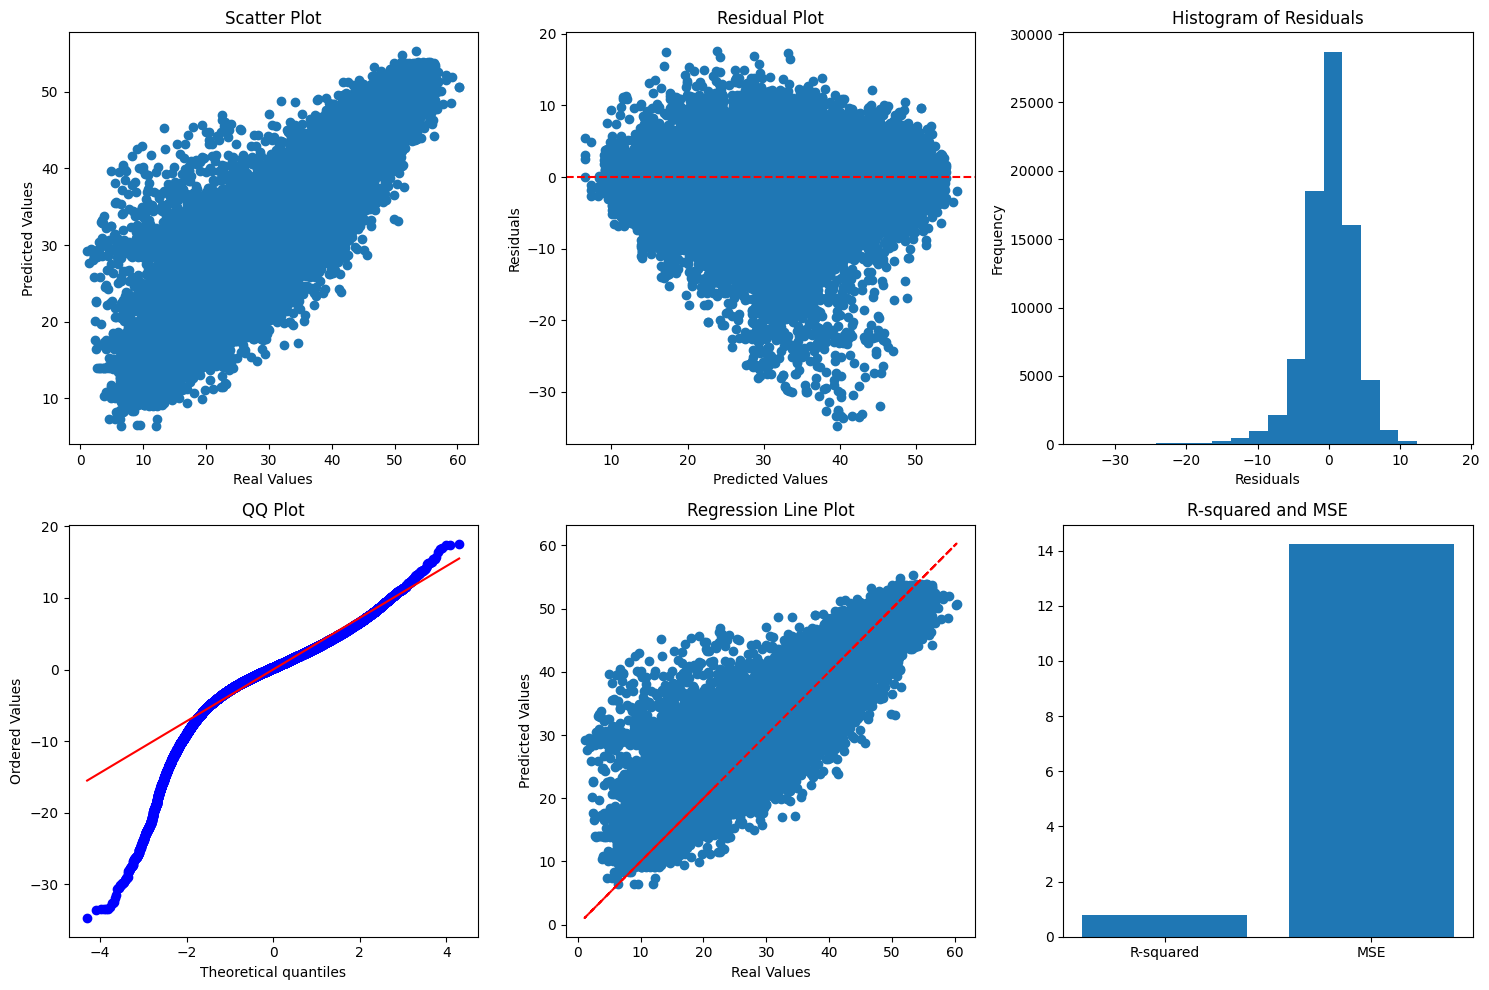

In [69]:
pred = model.predict(x_test)
print(f'test_data: {smape(y_test, pred)}')
plot_eval(pred, y_test)

train_data: 8.420519


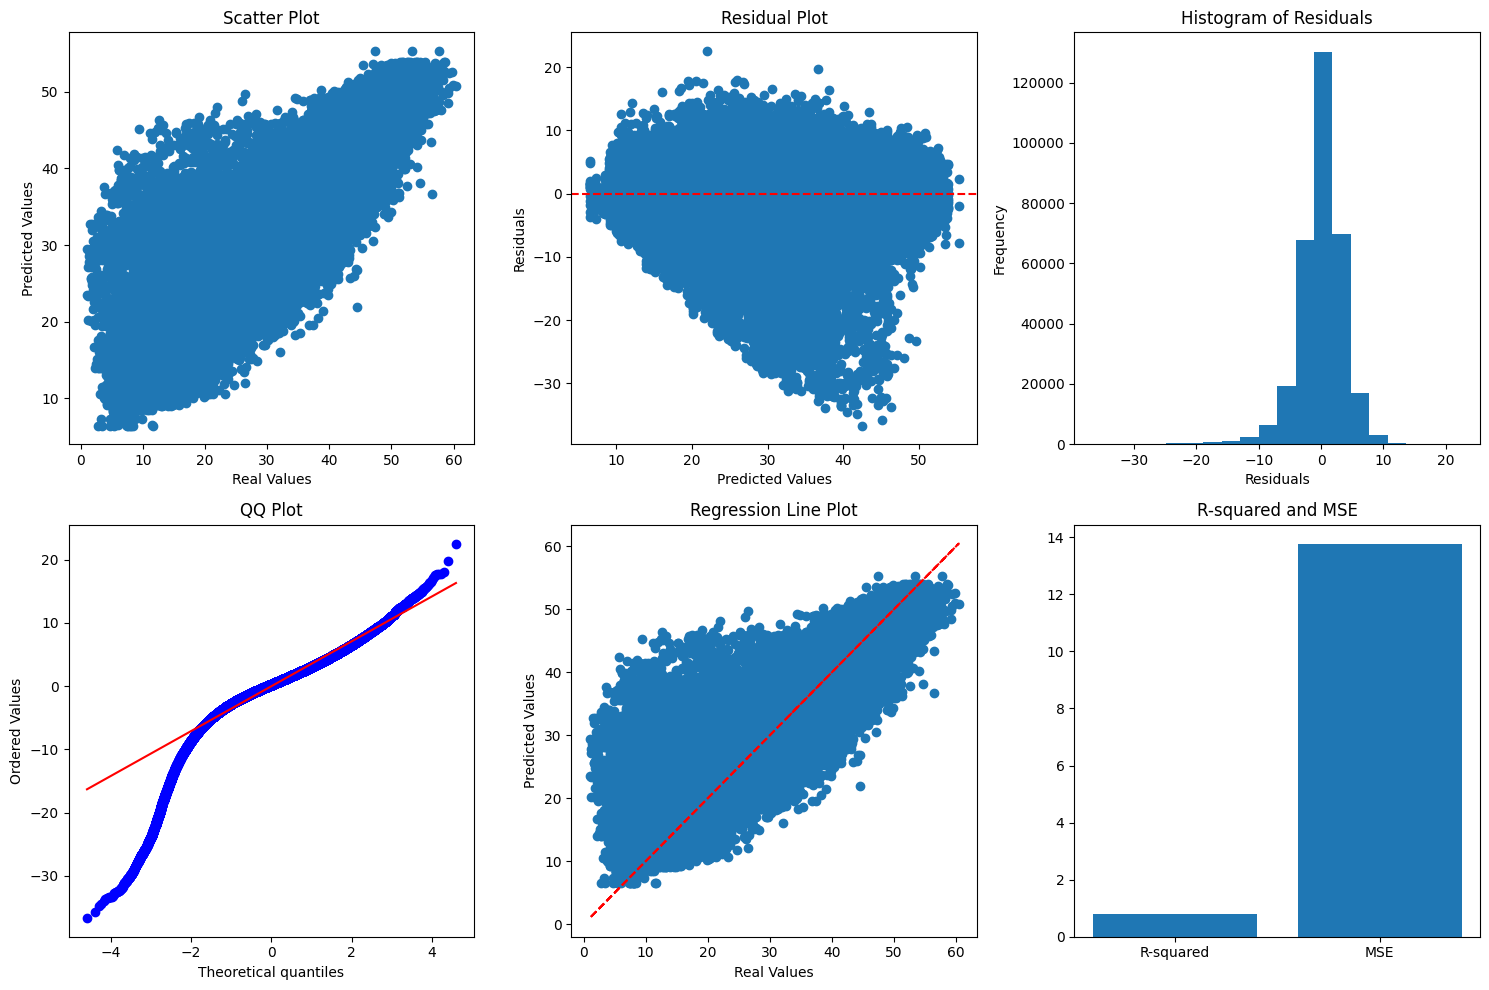

In [70]:
pred = model.predict(x_train)
print(f'train_data: {smape(y_train, pred)}')
plot_eval(pred, y_train)

In [63]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    
    
    n_estimators = trial.suggest_int("n_estimators", 1000, 5000)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 1.0, step=0.1)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 7, step=2)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1)
    reg_alpha = trial.suggest_float("reg_alpha", 0., 1.0, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 0., 1.0, step=0.1)
    seed = trial.suggest_int("random_state", 20, 50, step=2)
    
    
    model = xgboost.XGBRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                colsample_bytree=colsample_bytree,
                                subsample=subsample,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                n_jobs=-1, metric=mean_squared_error,
                                eval_metric=mean_squared_error,
                                random_state=seed
                                )
    
    model.fit(x_train, y_train)
    
    y_hat = model.predict(x_test)
    
    return mean_squared_error(y_test, y_hat, squared=True)

study = optuna.create_study()
study.optimize(objective, n_trials=20)

[I 2023-08-09 17:02:29,622] A new study created in memory with name: no-name-574b8b25-1e98-4aa3-a7c3-13777986582d
[I 2023-08-09 17:05:04,526] Trial 0 finished with value: 34.3238397504761 and parameters: {'n_estimators': 1582, 'max_depth': 7, 'learning_rate': 0.0015717999989744102, 'gamma': 0.6, 'min_child_weight': 1, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001, 'random_state': 30}. Best is trial 0 with value: 34.3238397504761.
[I 2023-08-09 17:11:34,552] Trial 1 finished with value: 90.31725635463336 and parameters: {'n_estimators': 3805, 'max_depth': 9, 'learning_rate': 0.0003912727767901208, 'gamma': 0.30000000000000004, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004, 'random_state': 44}. Best is trial 0 with value: 34.3238397504761.
[I 2023-08-09 17:17:57,593] Trial 2 finished with value: 344.79465530262104 and parameters: {'n_estimators': 4066, 'max_depth': 7, '

KeyboardInterrupt: 

[I 2023-08-09 15:01:50,824] Trial 13 finished with value: 3.5698679194559 and parameters: {'n_estimators': 2590, 'max_depth': 8, 'learning_rate': 0.010898852917742244, 'gamma': 0.30000000000000004, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5, 'random_state': 26}. Best is trial 12 with value: 3.5533699042727336.
[I 2023-08-09 15:17:28,806] Trial 15 finished with value: 3.5449906803696667 and parameters: {'n_estimators': 2552, 'max_depth': 9, 'learning_rate': 0.010419707354527082, 'gamma': 0.30000000000000004, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5, 'random_state': 28}. Best is trial 15 with value: 3.5449906803696667.
[I 2023-08-09 14:56:21,431] Trial 12 finished with value: 3.5533699042727336 and parameters: {'n_estimators': 4255, 'max_depth': 7, 'learning_rate': 0.011679890124365775, 'gamma': 0.1, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.5, 'reg_lambda': 0.2, 'random_state': 26}. Best is trial 12 with value: 3.5533699042727336.


In [71]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    
    subsample_for_bin = trial.suggest_int("subsample_for_bin", 100000, 300000)
    n_estimators = trial.suggest_int("n_estimators", 1000, 5000)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
    num_leaves = trial.suggest_int("num_leaves", 10, 50)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 7, step=2)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1)
    reg_alpha = trial.suggest_float("reg_alpha", 0., 1.0, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 0., 1.0, step=0.1)
    seed = trial.suggest_int("random_state", 20, 50, step=2)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 50)
    
    model = lgb.LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                              n_estimators=n_estimators, subsample_for_bin=subsample_for_bin, 
                              min_child_weight=min_child_weight, min_child_samples=min_child_samples, subsample=subsample, 
                              colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, 
                              reg_lambda=reg_lambda, random_state=seed, n_jobs=-1,)
    
    model.fit(x_train, y_train)
    
    y_hat = model.predict(x_test)
    
    return mean_squared_error(y_test, y_hat, squared=True)
    # return mean_squared_error(y_test*max_speed, y_hat*max_speed, squared=True)
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-08-09 19:23:40,466] A new study created in memory with name: no-name-184235f4-e14d-43bc-9225-90bc7ac66460
[I 2023-08-09 19:24:11,867] Trial 0 finished with value: 65.21823165866739 and parameters: {'subsample_for_bin': 154411, 'n_estimators': 3187, 'max_depth': 9, 'learning_rate': 5.5650178350425326e-06, 'num_leaves': 42, 'min_child_weight': 7, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 1.0, 'reg_lambda': 0.2, 'random_state': 42, 'min_child_samples': 19}. Best is trial 0 with value: 65.21823165866739.
[I 2023-08-09 19:24:47,556] Trial 1 finished with value: 66.01229344728932 and parameters: {'subsample_for_bin': 168181, 'n_estimators': 4107, 'max_depth': 6, 'learning_rate': 1.2292997320979525e-06, 'num_leaves': 38, 'min_child_weight': 7, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.8, 'random_state': 20, 'min_child_samples': 46}. Best is trial 0 with value: 65.21823165866739.
[I 2023-08-09 19:25:07,957] Trial 2 finished with value: 6

[I 2023-08-09 16:50:04,570] Trial 78 finished with value: 12.534454690626298 and parameters: {'subsample_for_bin': 155546, 'n_estimators': 3768, 'max_depth': 7, 'learning_rate': 0.04067420520019853, 'num_leaves': 50, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004, 'random_state': 34, 'min_child_samples': 16}. Best is trial 78 with value: 12.534454690626298.
[I 2023-08-09 16:58:36,247] Trial 93 finished with value: 12.533047460664628 and parameters: {'subsample_for_bin': 131673, 'n_estimators': 4510, 'max_depth': 6, 'learning_rate': 0.054834260577325884, 'num_leaves': 47, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004, 'random_state': 34, 'min_child_samples': 16}. Best is trial 93 with value: 12.533047460664628.
[I 2023-08-09 16:59:18,331] Trial 94 finished with value: 12.537393523821807 and parameters: {'subsample_for_bin': 122882, 'n_estimators': 4687, 'max_depth': 6, 'learning_rate': 0.05337881441549043, 'num_leaves': 48, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004, 'random_state': 34, 'min_child_samples': 17}. Best is trial 93 with value: 12.533047460664628.


In [ ]:
from catboost import CatBoostRegressor
import optuna



def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_float("l2_leaf_reg", 0., 1.0, step=0.1)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_int("iterations", 1000, 5000)
    param['loss_function'] = 'RMSE'

    param['random_state'] = trial.suggest_int("random_state", 20, 50, step=2)
    param['logging_level'] = 'Silent'
    
    model = CatBoostRegressor(**param)

    model.fit(x_train, y_train)
    
    y_hat = model.predict(x_test)
    
    return mean_squared_error(y_test, y_hat, squared=True)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

In [73]:
def xgb_1(no):
  param_1 = {'n_estimators': 2552, 'max_depth': 9, 'learning_rate': 0.010419707354527082, 'gamma': 0.30000000000000004, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5, 'random_state': 28}

  param_2 = {'n_estimators': 4627, 'max_depth': 10, 
             'learning_rate': 0.03031698197768738, 
             'gamma': 0.7000000000000001, 'min_child_weight': 7, 
             'subsample': 0.9, 'colsample_bytree': 1.0, 
             'reg_alpha': 0.30000000000000004, 
             'reg_lambda': 0.30000000000000004, 
             'random_state': 22, 'grow_policy' : 'depthwise', 
            'n_jobs' : -1}
  
  params = [param_1, param_2]
  xgb = xgboost.XGBRegressor(**params[no])
  return xgb

def lgbm_1(no):
  param_1 = {'subsample_for_bin': 131673, 'n_estimators': 4510, 'max_depth': 6, 'learning_rate': 0.054834260577325884, 'num_leaves': 47, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004, 'random_state': 34, 'min_child_samples': 16}

  param_2 = {'subsample_for_bin': 155546, 'n_estimators': 3768, 'max_depth': 7, 'learning_rate': 0.04067420520019853, 'num_leaves': 50, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004, 'random_state': 34, 'min_child_samples': 16}
  
  params = [param_1, param_2]
  lgbm = lgb.LGBMRegressor(**params[no])
  return lgbm

In [74]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


estimators1 = [('xgb_1{}'.format(i), xgb_1(i)) for i in range(1)]
estimators2 = [('lgbm_1{}'.format(j), lgbm_1(j))  for j in range(2)]
estimators = estimators1+estimators2

model = StackingRegressor(estimators=estimators, cv=3, final_estimator=LinearRegression(n_jobs=-1), n_jobs = -1, verbose=1)

In [75]:
model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.2min finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.3min finished


StackingRegressor(cv=3,
                  estimators=[('xgb_10',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.30000000000000004,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constr...
                                             reg_lambda=0.30000000000000004,
                                             subsample_for_bin=131673)),
                              ('lgbm_11',
                               LGBMRegressor(learning_rate=0.04067420520019853,
                                             max_depth=7, min_child_samples=16,
                                             min_child_weight=1,
                                             n_estimators=3768, num_leaves=50,
                                             random_state=34, reg_alpha=0.5,
                                             reg_lambda=0.30000000000000004,
                                             subsample=0.9,
                                             subsample_for_bin=155546))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
                  verbose=1)

In [78]:
import pickle
pickle.dump(model, open('stack_model_submission-2.pkl','wb'))

test_data: 7.851232


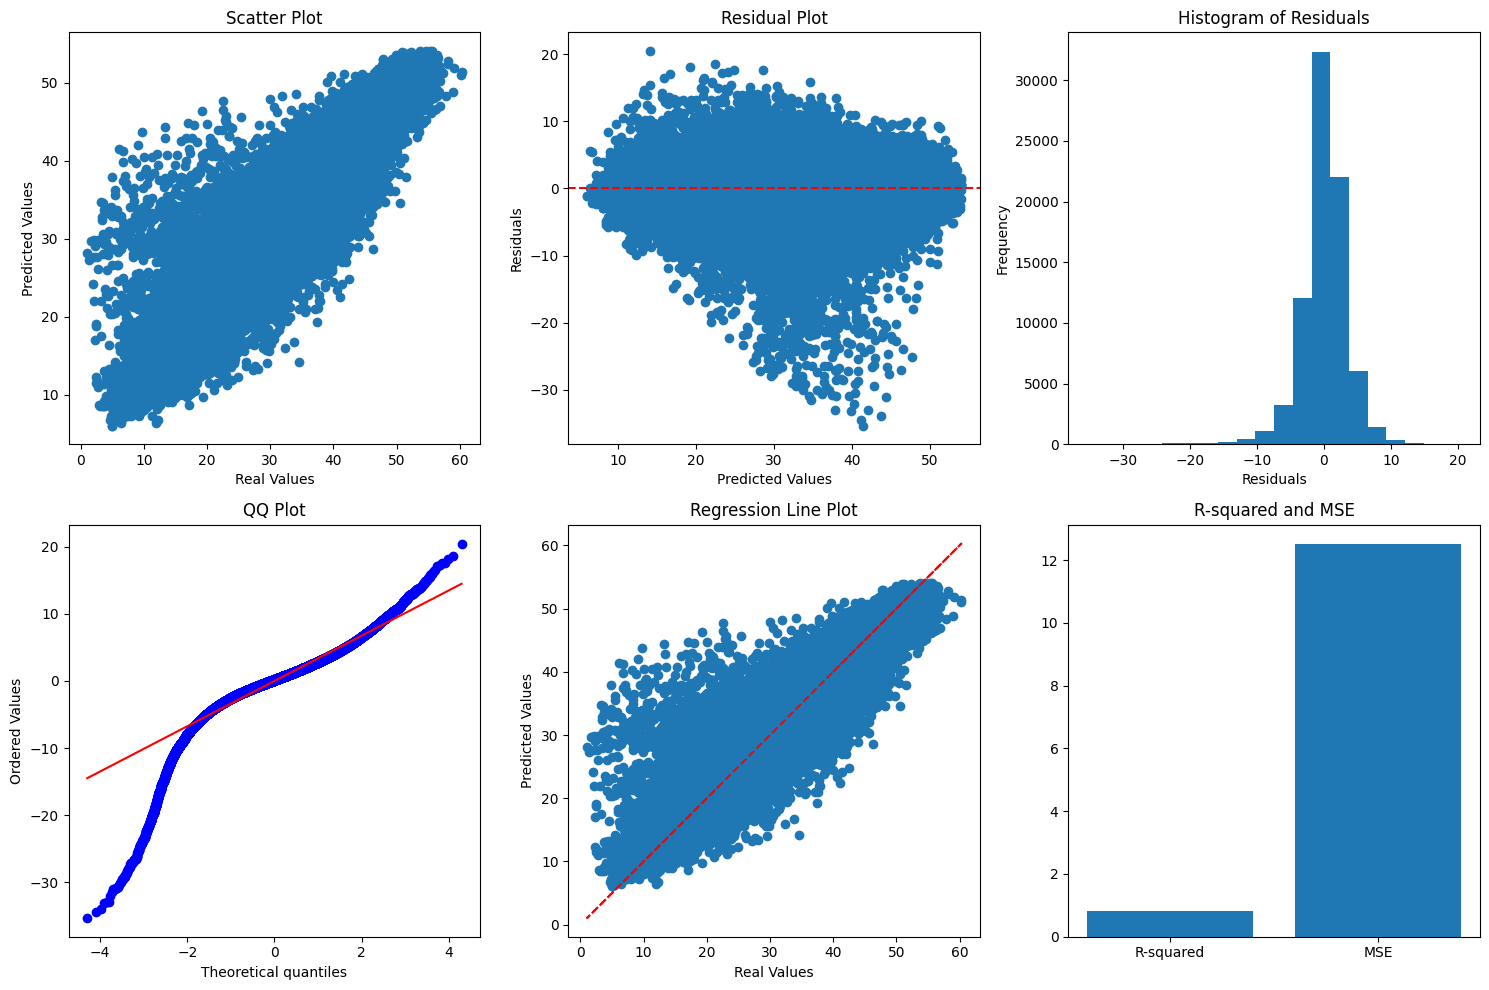

In [76]:
pred = model.predict(x_test)
print(f'test_data: {smape(y_test, pred)}')
plot_eval(pred, y_test)

train_data: 7.542713


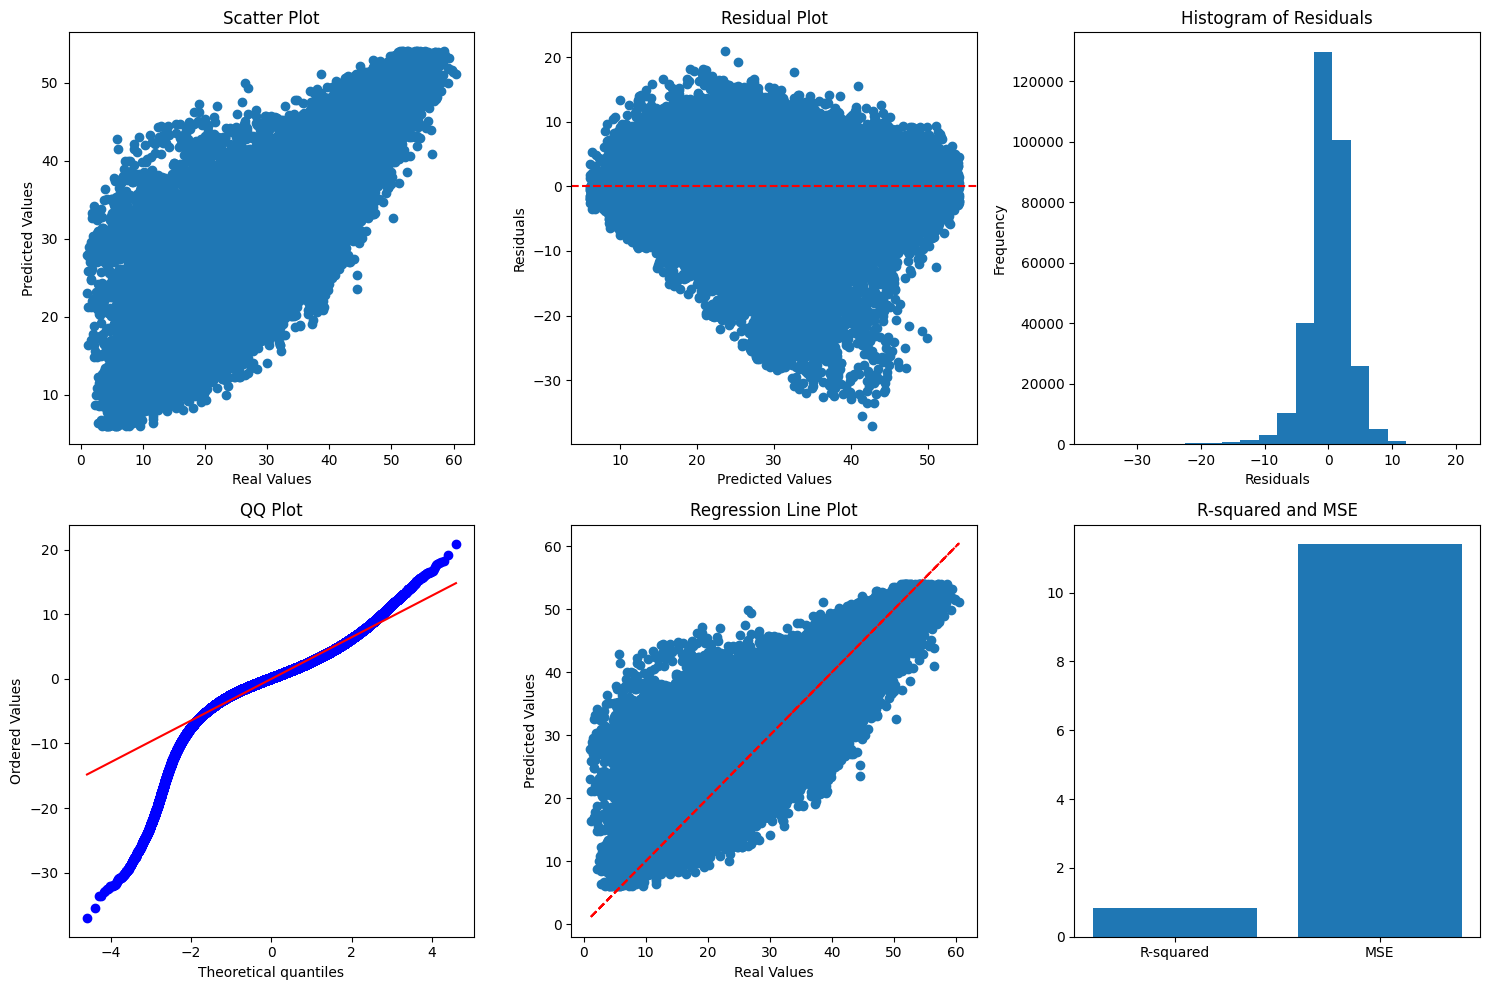

In [77]:
pred = model.predict(x_train)
print(f'train_data: {smape(y_train, pred)}')
plot_eval(pred, y_train)

In [84]:
df_test = pd.read_csv('new_test.csv')
df_test.head()

,id,waktu_setempat,id_jalan,id_titik_mulai,id_titik_akhir,lanes,lanes:forward,lit,maxspeed,mulai_lat,mulai_lon,akhir_lat,akhir_lon,distance
0,0,2020-02-23 00:00:00+00:00,4004732,32046542,6454026544,2.0,NaN,yes,30 mph,51.465182,-0.255240,51.465204,-0.254595,0.0311
1,1,2020-02-23 00:00:00+00:00,182210371,1314925464,1314925496,NaN,2.0,yes,30 mph,51.458973,-0.141882,51.459254,-0.141646,0.0416
2,2,2020-02-23 00:00:00+00:00,22932408,1482086782,26481020,NaN,NaN,yes,20 mph,51.449437,-0.160688,51.449295,-0.161060,0.0155
3,3,2020-02-23 00:00:00+00:00,182210371,3892883,267337489,NaN,2.0,yes,30 mph,51.457325,-0.143228,51.457466,-0.143110,0.0155
4,4,2020-02-23 00:00:00+00:00,66924592,266041030,2592978110,NaN,NaN,yes,30 mph,51.467314,-0.112842,51.466309,-0.113371,0.0889


In [85]:
df_test = prepare_data(df_test)
df_test.head()

time categorization: 100%|██████████| 127489/127489 [00:09<00:00, 13428.45it/s]


,id,id_jalan,id_titik_mulai,id_titik_akhir,maxspeed,mulai_lat,mulai_lon,akhir_lat,akhir_lon,distance,is_weekend,hour,date,is_night,is_rush_hour
0,0,4004732,32046542,6454026544,48.2803,51.465182,-0.255240,51.465204,-0.254595,0.0311,1,0,2020-02-23,0,1
1,1,182210371,1314925464,1314925496,48.2803,51.458973,-0.141882,51.459254,-0.141646,0.0416,1,0,2020-02-23,0,1
2,2,22932408,1482086782,26481020,32.1869,51.449437,-0.160688,51.449295,-0.161060,0.0155,1,0,2020-02-23,0,1
3,3,182210371,3892883,267337489,48.2803,51.457325,-0.143228,51.457466,-0.143110,0.0155,1,0,2020-02-23,0,1
4,4,66924592,266041030,2592978110,48.2803,51.467314,-0.112842,51.466309,-0.113371,0.0889,1,0,2020-02-23,0,1


In [86]:
data_test = df_test.drop(['id', 'id_jalan', 'id_titik_mulai', 'id_titik_akhir', 'date'], axis=1)
pred_test = model.predict(data_test)

In [87]:
subm = pd.read_csv('submissionV2.csv')
subm.head()

,id,rerata_kecepatan
0,0,41.504017
1,1,41.519714
2,2,34.982294
3,3,40.739993
4,4,32.622729


In [88]:
subm['rerata_kecepatan'] = pred_test
subm.head()

,id,rerata_kecepatan
0,0,43.013100
1,1,39.157854
2,2,36.455321
3,3,43.624972
4,4,30.233755


In [89]:
subm.to_csv('submission-new_data-v1.csv', index=False)